In [79]:
# Importing the libraries
import torch
#from torchviz import make_dot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import NN_classes

In [80]:
executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]

sc = "sc01"
period = "2030"
train_size = 0.9

In [81]:
dfs_in = dict()
dfs_out = dict()
for execution in executions:
    #Read the data from desired execution
    df_in_e = pd.read_csv(f"Data/RTS_24/input_f_{sc}_{execution}_{period}.csv",header=[0,1])
    df_out_e = pd.read_csv(f"Data/RTS_24/output_f_{sc}_{execution}_{period}.csv",header=[0,1])

    #Drop the first row because its useless 
    df_in_e = df_in_e.drop([0])
    df_out_e = df_out_e.drop([0])
    print(f"Data/input_f_{sc}_{execution}_{period}.csv")
    

    #Focus for now only on the real part of the input data: 
    df_in_e_r = df_in_e["Value_R"]
    df_in_e_i = df_in_e["Value_I"]
    #TODO drop irrelevant columns
    #df_in_e_i = df_in_e["Value_I"].loc[:, (df_in_e["Value_I"] != 0).any(axis=0)]
    #df_in_e_i = df_in_e["Value_I"].drop(["Node_1", "Node_2","Node_3","SolarPV_1","WindFarm_1"],axis=1)
    
    print(len(df_in_e_r.columns)+ len(df_in_e_i.columns))
    
    df_in_e_c = pd.concat([df_in_e_r,df_in_e_i],axis=1)
    df_out_e = df_out_e["Value"]
    dfs_in[execution] = df_in_e_c
    dfs_out[execution] = df_out_e


Data/input_f_sc01_Network_Line_Out_N_101_N_102_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_104_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_101_N_105_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_104_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_106_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_103_N_109_cac1_2030.csv
1312


In [87]:
ts_in  = dict()
ts_out = dict()

ts_in["train"] = dict()
ts_in["test"]  = dict()
ts_out["train"]= dict()
ts_out["test"] = dict()


test_size = 0.1

for execution in executions: 
    #Convert input dataframes numpy arrays sum the columns of the output: 
    np_in = dfs_in[execution].to_numpy()
    #We don't normalize the separate runs, but will do it afterward, all together
    #np_in = np_in/np.abs(np_in.max(axis=0))
    #np_in = np.nan_to_num(np_in,nan = 0)
    np_out = dfs_out[execution].to_numpy().sum(axis=1)

    #Convert to torch tensors
    t_in = torch.from_numpy(np_in)
    t_out = torch.from_numpy(np_out)

    #And split into train and test set:
    ts_in["train"][execution],ts_in["test"][execution],ts_out["train"][execution],ts_out["test"][execution]= train_test_split(t_in,t_out,test_size=test_size,shuffle=False)
#     train_size = 0.8
#     nb_train = int(train_size*len(t_out))
#     tr_in,te_in = t_in[:nb_train],t_in[nb_train:]
#     tr_out,te_out = t_out[:nb_train],t_out[nb_train:]
    
    

In [88]:
#concatenate all the training and testing sets to a single tensor, and normalize: 
first = True
for execution in executions:
    if first: 
        tr_in = ts_in["train"][execution]
        tr_out = ts_out["train"][execution]
        te_in = ts_in["test"][execution]
        te_out = ts_out["test"][execution]
        first = False
    else: 
        tr_in = torch.cat((tr_in,ts_in["train"][execution]))
        tr_out= torch.cat((tr_out,ts_out["train"][execution]))
        te_in = torch.cat((te_in,ts_in["test"][execution]))
        te_out= torch.cat((te_out,ts_out["test"][execution]))
maxs= torch.cat((tr_in,te_in)).abs().max(dim = 0).values
# maxs_te = te_in.abs().max(dim = 0).values
tr_in = torch.nan_to_num(tr_in/maxs)
te_in = torch.nan_to_num(te_in/maxs)

# for execution in executions: 
#     ts_in["train"][execution] = torch.nan_to_num(ts_in["train"][execution]/maxs)
#     ts_in["test"][execution] = torch.nan_to_num(ts_in["test"][execution]/maxs)

In [85]:
n_ts_in  = dict()

n_ts_in["train"] = dict()
n_ts_in["test"]  = dict()

for execution in executions: 
    n_ts_in["train"][execution] = torch.nan_to_num(ts_in["train"][execution]/maxs)
    n_ts_in["test"][execution] = torch.nan_to_num(ts_in["test"][execution]/maxs)

In [78]:
maxs

tensor([42.5532, 41.8410, 13.4264,  ...,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64)

In [70]:
torch.nan_to_num(ts_in["train"][executions[1]]/maxs)

tensor([[   0.0000,    0.0000,  180.2688,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,  180.2688,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,  180.2688,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [1417.7976, 1333.1459,  180.2688,  ...,    0.0000,    0.0000,
            0.0000],
        [1371.5651, 1237.9212,  180.2688,  ...,    0.0000,    0.0000,
            0.0000],
        [1309.9217, 1186.6464,  180.2688,  ...,    0.0000,    0.0000,
            0.0000]], dtype=torch.float64)

In [102]:
n_ts_in["train"][executions[3]]

tensor([[0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7830, 0.7615, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7574, 0.7071, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7234, 0.6778, 1.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [7]:
model_1 = NN_classes.ObjectiveEstimator_ANN_Single_layer(input_size=tr_in.shape[1],output_size=1)
model_2 = NN_classes.ObjectiveEstimator_ANN_3hidden_layer(input_size=tr_in.shape[1],hidden_size1=int(tr_in.shape[1]/4),hidden_size2=int(tr_in.shape[1]/16),hidden_size3=int(tr_in.shape[1]/64),output_size=1)
#NN_classes.train_and_get_loss(model_1,tr_in,tr_out,300,0.1,True)
NN_classes.train_and_get_loss(model_2,tr_in,tr_out,400,0.01,True)

Epoch 10, Train Loss: 29.916534423828125
Epoch 20, Train Loss: 4.303990364074707
Epoch 30, Train Loss: 6.27565336227417
Epoch 40, Train Loss: 1.920969843864441
Epoch 50, Train Loss: 2.3322017192840576
Epoch 60, Train Loss: 1.6038762331008911
Epoch 70, Train Loss: 1.4990445375442505
Epoch 80, Train Loss: 1.2320560216903687
Epoch 90, Train Loss: 0.9815346598625183
Epoch 100, Train Loss: 0.7110728025436401
Epoch 110, Train Loss: 0.42648574709892273
Epoch 120, Train Loss: 0.18533574044704437
Epoch 130, Train Loss: 0.05739932879805565
Epoch 140, Train Loss: 0.03312886133790016
Epoch 150, Train Loss: 0.029461123049259186
Epoch 160, Train Loss: 0.020306576043367386
Epoch 170, Train Loss: 0.01844417117536068
Epoch 180, Train Loss: 0.015878720209002495
Epoch 190, Train Loss: 0.014380699023604393
Epoch 200, Train Loss: 0.01309151854366064
Epoch 210, Train Loss: 0.012066176161170006
Epoch 220, Train Loss: 0.011179378256201744
Epoch 230, Train Loss: 0.010483302175998688
Epoch 240, Train Loss: 0.00

tensor(0.0046, grad_fn=<MseLossBackward0>)

In [9]:
NN_classes.train_and_get_loss(model_1,tr_in,tr_out,1000,0.1,True)


Epoch 10, Train Loss: 7.2117462158203125
Epoch 20, Train Loss: 4.422133445739746
Epoch 30, Train Loss: 1.4086689949035645
Epoch 40, Train Loss: 0.6932044625282288
Epoch 50, Train Loss: 0.4310845732688904
Epoch 60, Train Loss: 0.25999146699905396
Epoch 70, Train Loss: 0.1580292284488678
Epoch 80, Train Loss: 0.0984000563621521
Epoch 90, Train Loss: 0.06165822967886925
Epoch 100, Train Loss: 0.04418650269508362
Epoch 110, Train Loss: 0.037319596856832504
Epoch 120, Train Loss: 0.03381233662366867
Epoch 130, Train Loss: 0.03248011693358421
Epoch 140, Train Loss: 0.03182436153292656
Epoch 150, Train Loss: 0.03152991458773613
Epoch 160, Train Loss: 0.03138250485062599
Epoch 170, Train Loss: 0.031300950795412064
Epoch 180, Train Loss: 0.03125304356217384
Epoch 190, Train Loss: 0.0312208104878664
Epoch 200, Train Loss: 0.031195418909192085
Epoch 210, Train Loss: 0.031172866001725197
Epoch 220, Train Loss: 0.03115156665444374
Epoch 230, Train Loss: 0.0311308354139328
Epoch 240, Train Loss: 0.0

tensor(0.0305, grad_fn=<MseLossBackward0>)

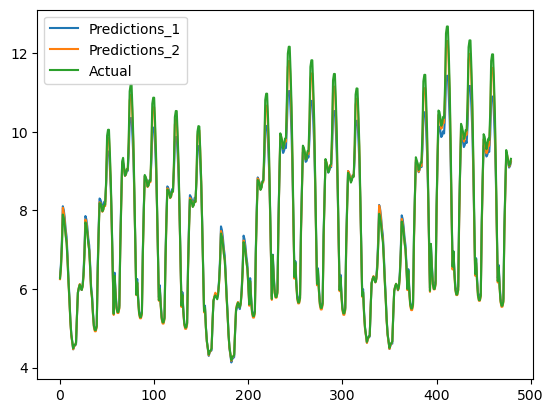

In [72]:
s=0
e=24*20
test_predictions_1 = model_1(te_in.float())
test_predictions_3 = model_1(ts_in["test"][executions[2]].float())
test_predictions_2 = model_2(te_in.float())
plt.plot(test_predictions_1.detach()[s:e],label = "Predictions_1")
plt.plot(test_predictions_2.detach()[s:e],label = "Predictions_2")
plt.plot(te_out[s:e],label = "Actual")
plt.legend()

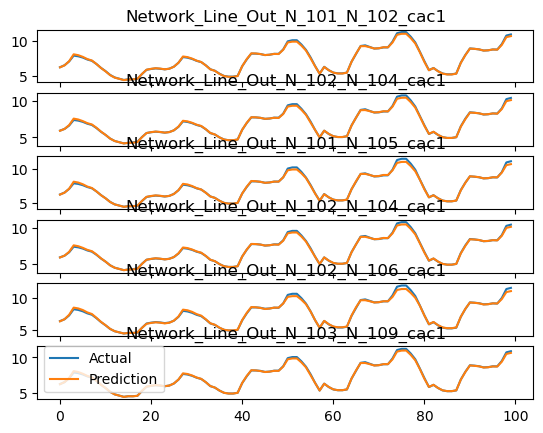

In [103]:
s=0
e=100
fig, axs = plt.subplots(len(executions))
i=0
for execution in executions:
    ax= axs[i]
    test_predictions_1 = model_1(n_ts_in["test"][execution][s:e].float())
    test_predictions_2 = model_2(n_ts_in["test"][execution][s:e].float())
    ax.plot(ts_out["test"][execution][s:e],label = "Actual")
    ax.plot(test_predictions_2.detach(),label = "Prediction")
    ax.set_title(execution)
    i+=1
plt.legend()

In [104]:
# Save the trained model
torch.save(model_2.state_dict(), "24_bus_3h.pth")
torch.save(model_1.state_dict(), "24_bus_sl.pth")
